In [1]:
# Data management
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Graphics
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modelling
# ------------------------------------------------------------------------------
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing

from sklearn.metrics import accuracy_score
from sklearn import metrics 


# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
#warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('CSV_DEF_REG.csv')
data.head()

,created_at,aid,extension,format,duration,FILE_STORED,FACIAL_ANALYSED,VOICE_ANALYSED,VOICE_TRANSCRIBED,BIOMETRICS_EXTRACTED,...,language,surprised_voice,no_speech_prob,entropy,tense_past,tense_present,tense_future,sentiment_polarity,sentiment_subjectivity,variable
0,1744824974,63612104-cc5c-4d54-b136-1f5880dece96,.mp4,video,NaN,True,True,False,True,False,...,en,NaN,0.006900,4.4125,0.3158,0.6842,0.0000,0.0932,0.5386,TDAH
1,1744825004,1afe2c00-8488-40f2-b3e1-5bd90fd57ad8,.mp4,video,213.0,True,True,True,True,True,...,en,0.043251,0.372388,4.3565,0.0769,0.9231,0.0000,0.2364,0.5069,TDAH
2,1744825017,6c987224-499c-469a-b908-dffef38c48b4,.mp4,video,115.0,True,True,True,True,True,...,es,0.190980,0.086458,4.1783,0.0000,1.0000,0.0000,0.3056,0.5162,Autismo
3,1744825025,e34d8573-7371-486a-900c-32a6ee78fabe,.mp4,video,202.0,True,True,True,True,True,...,es,0.006369,0.102629,4.2469,0.0833,0.7500,0.1667,0.2268,0.5349,Autismo
4,1744825037,5b442dc9-a39a-47e2-ba05-b0fe880ee44b,.mp4,video,135.0,True,True,True,True,True,...,es,0.047226,0.055492,4.2440,0.0833,0.9167,0.0000,0.2170,0.5825,Autismo


In [3]:
# Copia del dataframe original
df = data.copy()

# Columnas a eliminar (sin eliminar 'language')
cols_to_drop = [
    'created_at', 'aid', 'extension', 'format', 'duration',
    'FILE_STORED', 'FACIAL_ANALYSED', 'VOICE_ANALYSED', 'VOICE_TRANSCRIBED',
    'BIOMETRICS_EXTRACTED', 'SPEECH_ANALYSED', 'PERSONALITY_ANALYSED',
    'FACES_EXTRACTED', 'id'
]

# Eliminar columnas
df.drop(columns=cols_to_drop, inplace=True)

# Comprobación
print(f"Número de columnas tras la limpieza: {df.shape[1]}")
df.head()

Número de columnas tras la limpieza: 68


,angry_facial,disgust_facial,fear_facial,happy_facial,sad_facial,surprise_facial,neutral_facial,most_frequent_dominant_emotion,dominant_emotion_counts_surprise,average_face_confidence,...,language,surprised_voice,no_speech_prob,entropy,tense_past,tense_present,tense_future,sentiment_polarity,sentiment_subjectivity,variable
0,0.2098,0.0008,0.4117,0.1561,0.2053,0.0063,0.0099,sad,NaN,0.9500,...,en,NaN,0.006900,4.4125,0.3158,0.6842,0.0000,0.0932,0.5386,TDAH
1,0.0271,0.0000,0.1126,0.0005,0.6216,0.0001,0.2381,sad,NaN,0.9200,...,en,0.043251,0.372388,4.3565,0.0769,0.9231,0.0000,0.2364,0.5069,TDAH
2,0.1140,0.0000,0.1678,0.0062,0.4205,0.0020,0.2895,sad,NaN,0.9833,...,es,0.190980,0.086458,4.1783,0.0000,1.0000,0.0000,0.3056,0.5162,Autismo
3,0.0931,0.0771,0.1322,0.0408,0.3593,0.0007,0.2969,sad,NaN,0.9500,...,es,0.006369,0.102629,4.2469,0.0833,0.7500,0.1667,0.2268,0.5349,Autismo
4,0.0315,0.0001,0.0204,0.4411,0.2166,0.0009,0.2895,neutral,NaN,0.9167,...,es,0.047226,0.055492,4.2440,0.0833,0.9167,0.0000,0.2170,0.5825,Autismo


In [4]:
# Eliminar filas con clase 'Dispraxia'
df = df[df['variable'] != 'Dispraxia'].copy()

# Comprobación
print("Distribución de clases tras eliminar Dispraxia:")
print(df['variable'].value_counts())

Distribución de clases tras eliminar Dispraxia:
variable
Control     6155
Autismo     2113
TDAH        2030
Dislexia    2026
Name: count, dtype: int64


In [5]:
# Ver número de valores nulos por columna (ordenado)
df.isnull().sum().sort_values(ascending=False).head(20)

dominant_emotion_counts_surprise    10960
neutral_facial                       1381
disgust_facial                       1381
average_face_confidence              1381
most_frequent_dominant_emotion       1381
angry_facial                         1381
surprise_facial                      1381
sad_facial                           1381
happy_facial                         1381
fear_facial                          1381
voice_kurtosis                        560
voice_median                          560
voice_mode                            560
voice_Q25                             560
voice_Q75                             560
voice_IQR                             560
voice_skewness                        560
voice_Q75_note                        560
voice_mean_note                       560
voice_median_note                     560
dtype: int64

In [6]:
print ("Tamaño del dataset:", df.shape)

Tamaño del dataset: (12324, 68)


In [7]:
# Eliminar columna con demasiados nulos
df.drop(columns=['dominant_emotion_counts_surprise'], inplace=True)

In [8]:
columnas_con_nulos = df.columns[df.isnull().any()].tolist()

# 3. Rellenar según el tipo de dato
for col in columnas_con_nulos:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
        print(f"ℹ️ Columna categórica '{col}' rellenada con su moda")

# 4. Comprobar que ya no quedan nulos
total_nulos = df.isnull().sum().sum()
print(f"\n✅ Nulos restantes tras limpieza: {total_nulos}")

ℹ️ Columna categórica 'most_frequent_dominant_emotion' rellenada con su moda
ℹ️ Columna categórica 'voice_mean_note' rellenada con su moda
ℹ️ Columna categórica 'voice_median_note' rellenada con su moda
ℹ️ Columna categórica 'voice_mode_note' rellenada con su moda
ℹ️ Columna categórica 'voice_Q25_note' rellenada con su moda
ℹ️ Columna categórica 'voice_Q75_note' rellenada con su moda
ℹ️ Columna categórica 'language' rellenada con su moda

✅ Nulos restantes tras limpieza: 0


In [9]:
print ("Tamaño del dataset después (para comprobar que no se eliminan filas):", df.shape)

Tamaño del dataset después (para comprobar que no se eliminan filas): (12324, 67)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# 1. Separar X e y
X = df.drop(columns=['variable'])  # variable objetivo
y = df['variable']

# 2. Identificar columnas categóricas para codificar
columnas_categoricas = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Columnas categóricas a codificar:", columnas_categoricas)

# 3. Aplicar OneHotEncoding
X = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

# 4. Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Comprobación final
print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test:", X_test.shape)
print("Distribución de clases en y_train:\n", y_train.value_counts())

Columnas categóricas a codificar: ['most_frequent_dominant_emotion', 'voice_mean_note', 'voice_median_note', 'voice_mode_note', 'voice_Q25_note', 'voice_Q75_note', 'language']
Tamaño X_train: (9859, 179)
Tamaño X_test: (2465, 179)
Distribución de clases en y_train:
 variable
Control     4924
Autismo     1690
TDAH        1624
Dislexia    1621
Name: count, dtype: int64


In [11]:
# Paso 1: Crear variable binaria
df['target'] = df['variable'].apply(lambda x: 1 if x in ['Dislexia', 'TDAH', 'Autismo'] else 0)

# Paso 2: Separar variables
X = df.drop(columns=['variable', 'target'])
y = df['target']

# Seleccionamos tipos de columnas
from sklearn.compose import make_column_selector as selector
num_cols = selector(dtype_include=np.number)(X)
cat_cols = selector(dtype_exclude=np.number)(X)

print(f"Número de variables numéricas: {len(num_cols)}")
print(f"Número de variables categóricas: {len(cat_cols)}")


Número de variables numéricas: 59
Número de variables categóricas: 7


In [12]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline de preprocesado
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Pipeline completo
clf = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', SVC(kernel='rbf', random_state=42))
])

# Entrenar el modelo
clf.fit(X_train, y_train)

# Evaluación en test
test_accuracy = clf.score(X_test, y_test)
print(f"Accuracy en test: {test_accuracy:.3f}")

# Evaluación en entrenamiento
train_accuracy = clf.score(X_train, y_train)
print(f"Accuracy en train: {train_accuracy:.3f}")


Accuracy en test: 0.906
Accuracy en train: 0.946



Classification Report:
              precision    recall  f1-score   support

No Neurodiv.       0.87      0.95      0.91      1231
   Neurodiv.       0.95      0.86      0.90      1234

    accuracy                           0.91      2465
   macro avg       0.91      0.91      0.91      2465
weighted avg       0.91      0.91      0.91      2465



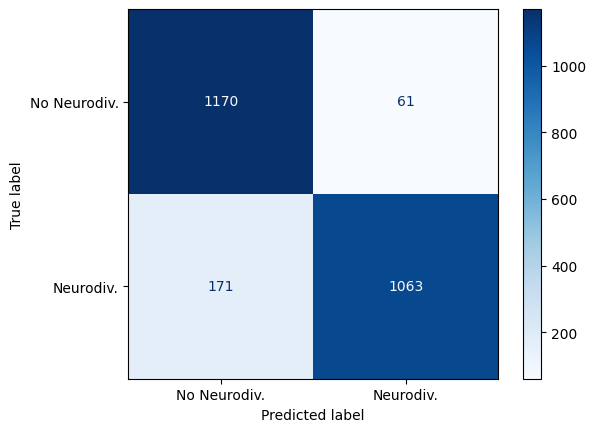

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Predicciones
y_pred = clf.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Neurodiv.", "Neurodiv."])
disp.plot(cmap='Blues')

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Neurodiv.", "Neurodiv."]))


🎯 Matriz de Confusión

- 1174 verdaderos negativos (No neurodiv. correctamente clasificados)

- 1067 verdaderos positivos (Neurodiv. correctamente clasificados)

- 57 falsos positivos (falsos neurodivergentes)

- 167 falsos negativos (neurodivergentes mal clasificados como control)